In [9]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(18432, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location=device))
model.eval()

/tmp/ipykernel_1539295/2644597714.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location=device))


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

# Background for SHAP
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
background, _ = next(iter(trainloader))
background = background.to(device)

# Test samples for explanation
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=5, shuffle=True)
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(device)


In [8]:
import shap

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images, ranked_outputs=10, check_additivity=False)

# explainer = shap.GradientExplainer(model, background)
# shap_values = explainer.shap_values(test_images)



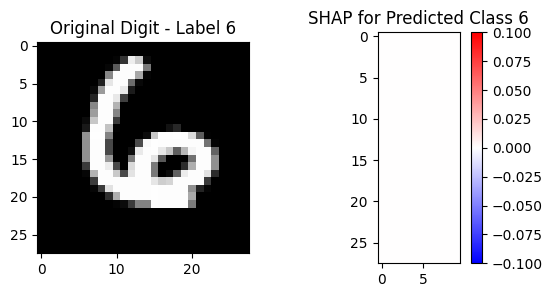

IndexError: index 1 is out of bounds for axis 0 with size 1

In [39]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import shap
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Define your model
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------
# Load model checkpoint
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location=device, weights_only=True))

model.eval()

# -------------------------
# Load MNIST test data
# -------------------------
transform = transforms.ToTensor()
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# Get first 10 test images
test_images = []
test_labels = []
for i, (img, label) in enumerate(testloader):
    test_images.append(img)
    test_labels.append(label)
    if i == 9:
        break

test_images = torch.cat(test_images, dim=0).to(device)  # (10, 1, 28, 28)
test_labels = torch.cat(test_labels, dim=0)

# -------------------------
# Create SHAP explainer
# -------------------------
background = test_images[:5]  # Use 5 images as background for SHAP
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images, check_additivity=False)  # test_images: 10 samples

# -------------------------
# Visualize SHAP explanations
# -------------------------

N = test_images.shape[0]
for i in range(N):
    image_tensor = test_images[i].unsqueeze(0)  # (1, 1, 28, 28)
    with torch.no_grad():
        pred_class = model(image_tensor).argmax().item()
        probs = torch.softmax(model(image_tensor), dim=1)
        confidence = probs[0][pred_class].item()

        shap_img = shap_values[pred_class][i][0]

    image_np = test_images[i][0].cpu().numpy()              # shape (28,28)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Original Digit - Label {test_labels[i].item()}")

    plt.subplot(1, 2, 2)
    plt.imshow(shap_img, cmap='bwr')  # Blue-White-Red heatmap
    plt.title(f"SHAP for Predicted Class {pred_class}")
    plt.colorbar()
    plt.show()

# for i in range(5):  # Show for 5 samples
#     pred_class = model(test_images[i].unsqueeze(0)).argmax().item()
#     image_np = test_images[i].cpu().numpy().squeeze()

#     try:
#         # shap_img = shap_values[pred_class][i][0]
#         shap_img = shap_values[0][i][0]
#         shap_img = np.array(shap_img)

#         if shap_img.ndim == 0:
#             print(f"Image {i}: Invalid SHAP image. Skipping.")
#             continue
#         if shap_img.ndim == 3 and shap_img.shape[0] == 1:
#             shap_img = shap_img.squeeze(0)

#         plt.figure(figsize=(6, 3))
#         plt.subplot(1, 2, 1)
#         plt.imshow(image_np, cmap='gray')
#         plt.title(f"True: {test_labels[i].item()}, Pred: {pred_class}")
#         plt.axis('off')

#         plt.subplot(1, 2, 2)
#         plt.imshow(shap_img, cmap='bwr')
#         plt.title(f"SHAP Explanation (Class {pred_class})")
#         plt.colorbar()
#         plt.axis('off')

#         plt.tight_layout()
#         plt.show()

    # except Exception as e:
    #     print(f"Error with image {i}: {e}")


In [21]:
shap_values = explainer.shap_values(test_images, ranked_outputs=10, check_additivity=False)

In [22]:
print("Length of shap_values:", len(shap_values))  # Should be 10 if multi-class
print("Shape of shap_values[0]:", shap_values[0].shape)  # Should be (N, 1, 28, 28)


Length of shap_values: 2
Shape of shap_values[0]: (10, 1, 28, 28, 10)


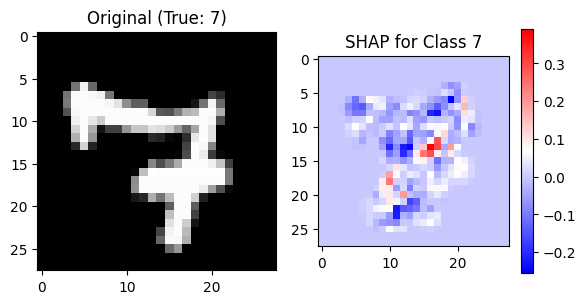

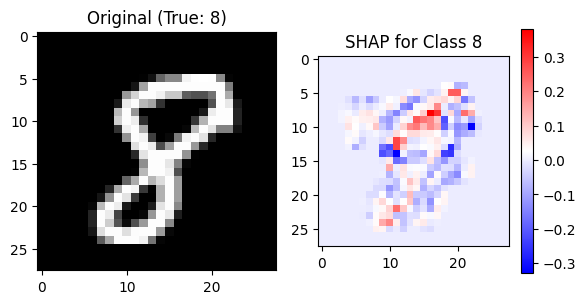

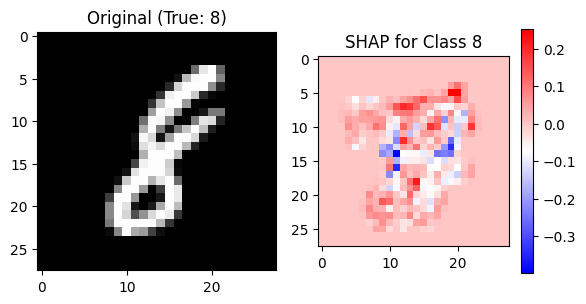

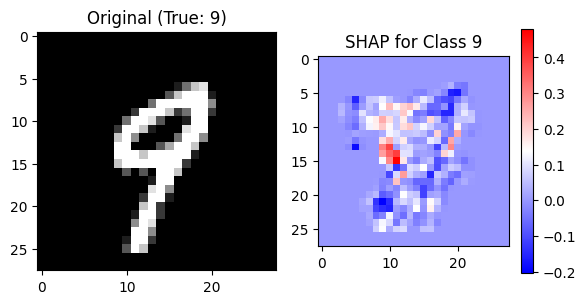

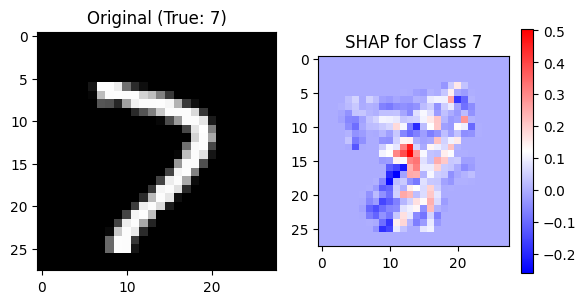

In [24]:
for i in range(5):  # Show for first 5 test images
    try:
        image_tensor = test_images[i].unsqueeze(0).to(device)
        pred_class = model(image_tensor).argmax().item()

        # Get SHAP values for this image and predicted class
        shap_img = shap_values[0][i][0][..., pred_class]  # already a NumPy array
        image_np = test_images[i][0].cpu().numpy()

        # Plot original and SHAP explanation
        plt.figure(figsize=(6, 3))

        plt.subplot(1, 2, 1)
        plt.imshow(image_np, cmap='gray')
        plt.title(f"Original (True: {test_labels[i].item()})")

        plt.subplot(1, 2, 2)
        plt.imshow(shap_img, cmap='bwr')  # red/blue colormap
        plt.title(f"SHAP for Class {pred_class}")
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error with image {i}: {e}")

/tmp/ipykernel_1901056/3909102126.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location='cpu'))


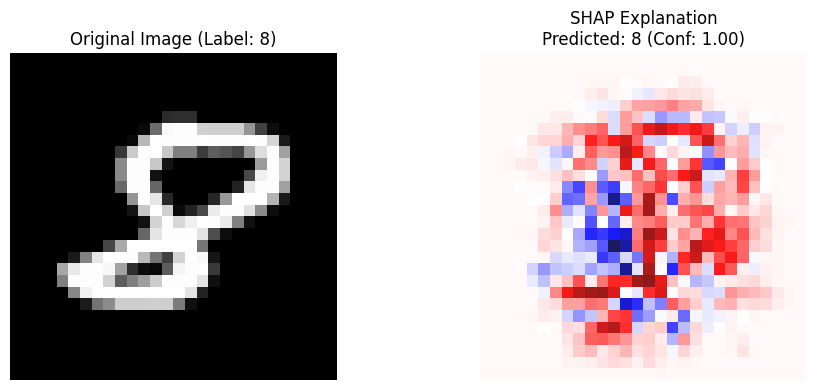

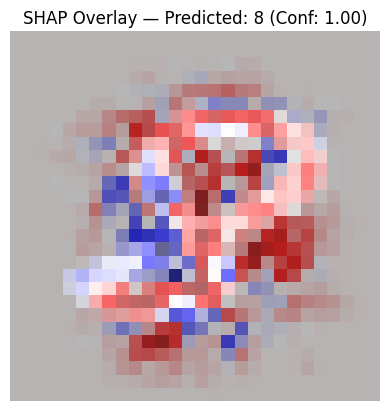

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import shap
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Load the CNN model
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(18432, 128)  # use correct flattened size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN()
model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location='cpu'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -----------------------------
# 2. Load MNIST test image (digit 5)
# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

for i in range(len(mnist)):
    if mnist[i][1] == 8:
        image, true_label = mnist[i]
        break

# idx = 5
# image, true_label = mnist[idx]
input_tensor = image.unsqueeze(0).to(device)  # shape (1, 1, 28, 28)

# -----------------------------
# 3. Background dataset (for SHAP)
# -----------------------------
background = torch.stack([mnist[i][0] for i in range(100)]).to(device)

# -----------------------------
# 4. SHAP explanation
# -----------------------------
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(input_tensor, ranked_outputs=1, check_additivity=False)

# Get prediction and confidence
with torch.no_grad():
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=1)
    pred_class = torch.argmax(probs).item()
    confidence = probs[0, pred_class].item()

# -----------------------------
# 5. Visualize SHAP output
# -----------------------------
# shap_values[0]: corresponds to top predicted class
shap_img = shap_values[0][0][0]  # shape (28,28), already numpy

# Convert input image to numpy
image_np = image.squeeze().numpy()

# -----------------------------
# 6. Plot
# -----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title(f"Original Image (Label: {true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(shap_img, cmap='seismic', alpha=0.9)
plt.title(f"SHAP Explanation\nPredicted: {pred_class} (Conf: {confidence:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()



# Plot SHAP values overlaid on image
# plt.imshow(image.squeeze(), cmap='gray', alpha=0.7)
# plt.imshow(shap_img, cmap='seismic', alpha=0.6)
# plt.title(f"SHAP Overlay — Predicted: {pred_class} (Conf: {confidence:.2f})")
# plt.axis('off')
# plt.show()

plt.imshow(image.squeeze(), cmap='gray', alpha=0.7)
plt.imshow(shap_img, cmap='seismic', alpha=0.6)
plt.title(f"SHAP Overlay — Predicted: {pred_class} (Conf: {confidence:.2f})")
plt.axis('off')
plt.show()

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import shap
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1. Define CNN Model
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------
# 2. Load model
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location=device))
model.eval()

# -------------------------
# 3. Load MNIST data
# -------------------------
transform = transforms.ToTensor()
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Choose a digit 5 image
image_idx = 5
input_image, true_label = mnist[image_idx]
input_tensor = input_image.unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]

# -------------------------
# 4. Background dataset for SHAP (e.g., 100 samples)
# -------------------------
background = torch.stack([mnist[i][0] for i in range(200)]).to(device)

# -------------------------
# 5. SHAP Explanation
# -------------------------
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(input_tensor, ranked_outputs=1, check_additivity=False)

# -------------------------
# 6. Prediction and Confidence
# -------------------------
output = model(input_tensor)
probs = torch.nn.functional.softmax(output, dim=1)
pred_class = torch.argmax(probs).item()
confidence = probs[0, pred_class].item()

print(f"Predicted class: {pred_class} with confidence: {confidence*100:.2f}% (True label: {true_label})")

# -------------------------
# 7. Plot SHAP values for predicted class
# -------------------------
# shap_img = shap_values[pred_class][0][0].cpu().detach().numpy()
# shap_img = shap_values[0][0][0]

# original_img = input_tensor[0][0].cpu().numpy()




# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(original_img, cmap='gray')
# plt.title(f"Original Digit: {true_label}")

# plt.subplot(1, 2, 2)
# plt.imshow(shap_img, cmap='bwr')
# plt.title(f"SHAP Explanation (Class {pred_class})\nConfidence: {confidence*100:.2f}%")
# plt.colorbar()
# plt.tight_layout()
# plt.show()

for idx in range(5):
    input_image, true_label = mnist[idx]
    input_tensor = input_image.unsqueeze(0).to(device)
    base_value = explainer.expected_value[0]  # for class 0 (or use [pred_class] if ranked_outputs=1)
    print("Base value (expected logit):", base_value)

    base_tensor = torch.tensor(base_value).unsqueeze(0)
    softmax_confidence = F.softmax(base_tensor, dim=1).numpy()
    print("Base confidence (approx):", softmax_confidence)
    # SHAP values for predicted class only
    shap_values = explainer.shap_values(input_tensor, ranked_outputs=1, check_additivity=False)
    shap_img = shap_values[0][0][0]  # Shape: (28, 28)

    # Model prediction
    output = model(input_tensor)
    probs = torch.nn.functional.softmax(output, dim=1)
    pred_class = torch.argmax(probs).item()
    confidence = probs[0, pred_class].item()

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_tensor[0][0].cpu().numpy(), cmap='gray')
    plt.title(f"Original Digit: {true_label}")

    plt.subplot(1, 2, 2)
    plt.imshow(shap_img, cmap='bwr')
    plt.title(f"SHAP Explanation (Class {pred_class})\nConfidence: {confidence*100:.2f}%")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1901056/2092154331.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simple_mnist_cnn.pth", map_location=device))


Predicted class: 1 with confidence: 100.00% (True label: 1)
Base value (expected logit): -6.479028


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [6]:
explainer = shap.GradientExplainer(model, background)
shap_values, indexes = explainer.shap_values(input_tensor, ranked_outputs=1)
print(shap_values[0].shape)  

print(len(shap_values))  

with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred_class = torch.argmax(probs).item()
    confidence = probs[0, pred_class].item()

shap_img = shap_values[pred_class][0, :, :, 0]  # shape (28, 28)

# Get original image
original_img = input_tensor[0][0].cpu().numpy()

# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title(f"Original Digit: {true_label}")
plt.axis('off')

plt.subplot(1, 2, 2)
im = plt.imshow(shap_img, cmap='bwr', vmin=-0.1, vmax=0.1)
plt.title(f"Gradient SHAP for Class {pred_class}\nConfidence: {confidence*100:.2f}%")
plt.colorbar(im)
plt.axis('off')

plt.tight_layout()
plt.show()

(1, 28, 28, 1)
1


IndexError: index 7 is out of bounds for axis 0 with size 1

In [55]:
def model_fn(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1, 28, 28).to(device)
    return model(x_tensor).detach().cpu().numpy()

explainer = shap.KernelExplainer(model_fn, background[:10].cpu().numpy().reshape(10, -1))
shap_values = explainer.shap_values(input_tensor.cpu().numpy().reshape(1, -1))


100%|██████████| 1/1 [00:04<00:00,  4.48s/it]
